### CONFIGURATION

In [4]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [62]:
#CHROM SLICING
minChromFrac = 17.443476
maxChromFrac = 17.491846

In [63]:
# BED FILE
#BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthSetNew/"
#BED_FILE_NAME = "union13callableMQonlymerged_addcert_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs_v2.19_2mindatasets_5minYesNoRatio.bed"
BED_FILE_NAME = "na12878-na24385-somatic-truth-regions.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'70-30truth'}
#VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthSetNew/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"
# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/160524/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

<h3> Load VCFs and Prepare DF

In [8]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
bed.reverse()

reading BED file
Bed File Loaded


In [61]:
## LOAD TRUTH SET VCF
truthBed = copy.deepcopy(bed)
dfTruth = aVCF.loadVaraintsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,truthBed)
dfTruth = dfTruth[(dfTruth.chromFrac > minChromFrac)&(dfTruth.chromFrac < maxChromFrac)]

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
Number variants loaded: 1101868


In [64]:
# LOAD SAMPLE VCF + match to truth set
sampleBed = copy.deepcopy(bed)
df = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,False)#True,sampleBed)
df['Truth']=df.chromPos.isin(dfTruth['chromPos']) 
df = df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]


reading vcf file: CPCT02010267R_CPCT02010267T_merged_somatics.vcf
Number variants loaded: 44651


<h3> SLICE ANALYSIS

In [27]:
sliceBed = copy.deepcopy(bed)

In [33]:
# SLICE SETTINGS
SLICE_VCF_PATH = "/Users/peterpriestley/hmf/sliceCPCT02101267/"
SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
SLICE_SAMPLE_NAMES = SAMPLE_NAMES 
dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,True,sliceBed)
dfSlice['Truth']=dfSlice.chromPos.isin(dfTruth['chromPos']) 
dfSlice = dfSlice[(dfSlice.chromFrac > minChromFrac)&(dfSlice.chromFrac < maxChromFrac)]

reading vcf file: somatics.merged.vcf
Number variants loaded: 281


In [66]:
#PRECISION + SENSITIVITY by caller
outputdata = []
for columnName in list(df):
    if columnName.endswith('allele'):
        myCaller = columnName[:-6]
        variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
        for variantType in variantTypes:
            truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
            positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
            truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
            falseNegatives = truthSet - truePositives
            if positives > 0:
                outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
outputDF = pd.DataFrame(outputdata)
outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
outputDF.sort_values(['variantType','caller'])

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,281,1151,0,-870,1.0,4.0961
1,INDEL,strelka,281,23,0,258,1.0,0.0819
3,INDEL,varscan,281,1277,0,-996,1.0,4.5445
5,SNP,freebayes,281,13364,0,-13083,1.0,47.5587
4,SNP,mutect,281,20744,0,-20463,1.0,73.8221
0,SNP,strelka,281,8275,0,-7994,1.0,29.4484
2,SNP,varscan,281,4678,0,-4397,1.0,16.6477


In [29]:
dfSlice[['Truth','numCallers','pos','variantType']].groupby(['Truth','variantType','numCallers']).agg('count')


,,,pos
Truth,variantType,numCallers,


In [36]:
#PRECISION + SENSITIVITY by caller - SLICE
outputdata = []
for columnName in list(dfSlice):
    if columnName.endswith('allele'):
        myCaller = columnName[:-6]
        variantTypes = dfSlice[(dfSlice[myCaller+'allele'] != '')].variantType.unique()
        for variantType in variantTypes:
            truePositives = len(dfSlice[(dfSlice[myCaller+'allele'] != '') & (dfSlice['Truth'] == True) &(dfSlice['variantType'] == variantType)])
            positives = len(dfSlice[(dfSlice[myCaller+'allele'] != '')&(dfSlice['variantType'] == variantType)])
            truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
            falseNegatives = truthSet - truePositives
            if positives > 0:
                outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
outputDF = pd.DataFrame(outputdata)
outputDF
outputDF.columns = (['variantType','caller','truth','TP','FP','FN','precision','sensitivity'])
outputDF.sort_values(['variantType','caller'])
outputDF[outputDF.caller != 'mutect2'].sort_values(['variantType','caller'])

,variantType,caller,truth,TP,FP,FN,precision,sensitivity
5,INDEL,freebayes,281,126,0,155,1.0,0.4484
1,INDEL,strelka,281,6,0,275,1.0,0.0214
2,INDEL,varscan,281,12,0,269,1.0,0.0427
6,SNP,freebayes,281,85,0,196,1.0,0.3025
4,SNP,mutect,281,27,0,254,1.0,0.0961
0,SNP,strelka,281,36,0,245,1.0,0.1281
3,SNP,varscan,281,13,0,268,1.0,0.0463


# False Negative Analysis

In [42]:
unfilteredBed = copy.deepcopy(bed)

In [43]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/slice2-70-30/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

reading vcf file: varscan.snp.vcf
Number variants loaded: 3308


In [44]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [45]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')


inSlice   pos
variantType inUnfilteredvarscan               
INDEL       False                    146   146
SNP         False                     73    73
            True                    1111  1111

In [46]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [47]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter',myCaller+'somaticGenotype']].groupby(['variantType','inSlice'+myCaller,'Truth','filter',myCaller+'somaticGenotype']).agg('count')


pos
variantType      inSlicevarscan Truth filter varscansomaticGenotype      
Missing Genotype False          False PASS                            108
                                      str10                             5
SNP              False          False PASS   1                       2002
                                             2                         13
                                             3                          3
                                      str10  1                         44
                                             2                         22
                                True  PASS   1                          1
                                             2                       1098
                                      str10  2                         12

In [48]:

dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

Series([], Name: pos, dtype: object)

In [49]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGenotype'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'qualityScore'],ascending=False)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,varscanallele,varscanallelicFreq,varscanreadDepth,varscanqualityScore,varscansomaticGenotype,patientName,Truth,inSlicevarscan,inSlice
477,17,56594197,17:56594197,17.697014,C,,1,SNP,,PASS,T,0.6154,117,82,1,CPCT11111111,False,False,False
478,17,56594460,17:56594460,17.697017,G,,1,SNP,,PASS,A,0.6111,108,75,1,CPCT11111111,False,False,False
851,17,56968181,17:56968181,17.701620,T,,1,SNP,,PASS,C,0.6609,116,74,1,CPCT11111111,False,False,False
978,17,57131581,17:57131581,17.703632,T,,1,SNP,,PASS,A,0.5981,107,73,1,CPCT11111111,False,False,False
379,17,56473259,17:56473259,17.695524,T,,1,SNP,,PASS,C,0.6211,95,72,1,CPCT11111111,False,False,False
15,17,56003908,17:56003908,17.689744,A,,1,SNP,,PASS,G,0.5865,104,69,1,CPCT11111111,False,False,False
347,17,56448052,17:56448052,17.695214,A,,1,SNP,,PASS,G,0.6154,91,69,1,CPCT11111111,False,False,False
371,17,56470511,17:56470511,17.695491,G,,1,SNP,,PASS,A,0.6698,106,65,1,CPCT11111111,False,False,False
463,17,56575208,17:56575208,17.696780,G,,1,SNP,,PASS,A,0.5532,95,65,1,CPCT11111111,False,False,False
936,17,57076893,17:57076893,17.702959,T,,1,SNP,,PASS,A,0.7132,136,64,1,CPCT11111111,False,False,False


In [25]:
dfSlice[dfSlice.pos=='38906100'].head(10)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,strelkaallele,strelkaallelicFreq,strelkareadDepth,strelkaqualityScore,strelkasomaticGenotype,varscanallele,varscanallelicFreq,varscanreadDepth,varscanqualityScore,varscansomaticGenotype,mutectallele,mutectallelicFreq,mutectreadDepth,mutectqualityScore,mutectsomaticGenotype,freebayesallele,freebayesallelicFreq,freebayesreadDepth,freebayesqualityScore,freebayessomaticGenotype,patientName,Truth


In [26]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'qualityScore'],ascending=False)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,strelkaallele,strelkaallelicFreq,strelkareadDepth,strelkaqualityScore,strelkasomaticGenotype,patientName,Truth,inSlicestrelka,inSlice


In [ ]:
#df_pivot = df[['numCallers','pos','variantType']].groupby(['variantType','numCallers',]).agg('count')
#df_pivot.groupby(level=0).transform(lambda x: x/x.sum())

<h3> SNP

In [71]:
snpdf = df[(df.variantType == 'SNP')]

In [72]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

,pos
Truth,
True,42264


In [73]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

Truth,True
numCallers,
1,38262
2,3258
3,693
4,51


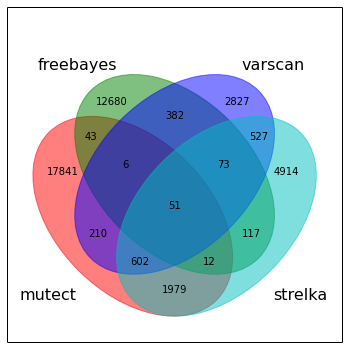

In [74]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [75]:
indeldf= df[(df.variantType == 'INDEL')]

In [76]:
pd.pivot_table(indeldf, values='pos', index=['numCallers','vennSegment'], columns=['Truth'], aggfunc='count')

,Truth,True
numCallers,vennSegment,
1,,2327
2,,56
3,,4


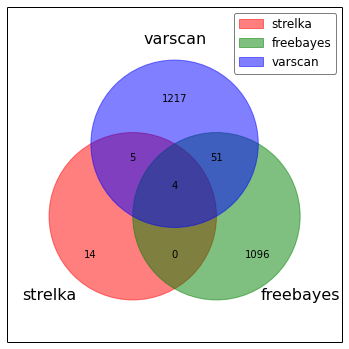

In [77]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

<h3> Allelic Depth

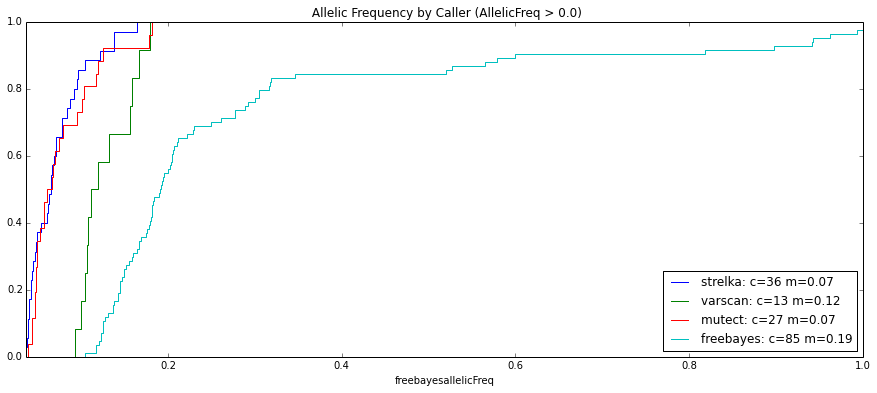

In [65]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'allelicFreq'] > 0.0)][columnName[:-6] + 'allelicFreq']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''